In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-5d6z1a9m
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-5d6z1a9m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-sw9zkzqv/pydoe_931b94c119b04ed8becc2f691162f759
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-sw9zkzqv/pydoe_931b94c119b04ed8becc2f691162f759
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 316 kB 25.0 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=1cddbd19699ba70f97879b7c87f9a4a1c04b84f28678b0f28c58106e167be270
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benchmark.bbobbenchmarks import F9
from bayes_optim.search_space import RealSpace

In [3]:
dim = 2
lb, ub = -5, 5
space = RealSpace([lb, ub]) * dim
f_name = 'f9'
f = F9

samples = space.sample(50000)

In [4]:
def fix_numeric_data(df):
  regrets = [float(x[1:-1]) for x in df['regret'].tolist()]
  df['regret'] = regrets
  return df

In [5]:
def minmax_normalisation():
  minmax = []
  for i in range(50):
    func = f(i)
    minmax.append(func(samples).max() - func.getfopt())
  return minmax

In [6]:
def abs_normalisation():
  n = []
  for i in range(50):
    func = f(i)
    n.append(func(samples).mean() - func.getfopt())
  return n

In [12]:
cma_es = fix_numeric_data(pd.read_csv(f'{f_name}_cma_es_doe_normalized.csv')[['regret', 'f_s']]).rename(columns={'regret': 'cma_es_regret'})
cma_es_init = fix_numeric_data(pd.read_csv(f'{f_name}_lhs_initial_doe_normalized.csv')[['regret', 'f_s']]).rename(columns={'regret': 'lhs_init_regret'})
uniform = fix_numeric_data(pd.read_csv(f'uniform_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'uniform_regret'})
lhs = fix_numeric_data(pd.read_csv(f'lhs_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'lhs_regret'})
halton = fix_numeric_data(pd.read_csv(f'halton_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'halton_regret'})
sobol = fix_numeric_data(pd.read_csv(f'sobol_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'sobol_regret'})
stats = cma_es.merge(uniform.merge(lhs.merge(sobol.merge(halton.merge(cma_es_init)))))
stats['minmax_norm'] = minmax_normalisation()
stats['abs_norm'] = abs_normalisation()
stats.head()

,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
0,0.663671,0,7.871626,7.987268,0.948432,1.980730,1.158260,245056.591807,15261.895339
1,2.632773,1,0.613708,1.259330,35.314736,1.258125,3.501588,316144.821473,17840.839025
2,1.376448,2,8.636624,11.397823,1.080733,2.353210,9.845075,316854.925567,17607.437825
3,1.291830,3,13.714469,0.089657,3.516776,1.179184,13.603137,250279.230704,16675.333467
4,1.137312,4,10.843660,1.091171,7.726755,0.935026,0.613578,161321.249174,13853.918557


# CMA-ES vs first individual (generated by LHS)

In [13]:
cma_init = stats.loc[stats['cma_es_regret'] < stats['lhs_init_regret']]
print(f'CMA-ES improved lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret']]

CMA-ES improved lhs DoE on 26, (52.0%) function instances


,f_s,cma_es_regret,lhs_init_regret
0,0,0.663671,1.158260
1,1,2.632773,3.501588
2,2,1.376448,9.845075
3,3,1.291830,13.603137
6,6,1.416331,5.806288
7,7,2.281067,3.188178
8,8,1.821276,2.777489
10,10,0.029826,2.246077
13,13,2.409652,6.896790
15,15,1.277202,5.563395


In [14]:
cma_init = stats.loc[stats['cma_es_regret'] > stats['lhs_init_regret']]
print(f'CMA-ES worstened lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret']]

CMA-ES worstened lhs DoE on 24, (48.0%) function instances


,f_s,cma_es_regret,lhs_init_regret
4,4,1.137312,0.613578
5,5,1.209525,1.068427
9,9,2.214928,1.129575
11,11,8.083735,3.452043
12,12,1.115279,0.212665
14,14,13.894311,7.067577
17,17,9.091213,7.581802
18,18,18.491337,7.317862
19,19,8.116658,0.768788
20,20,0.555215,0.098796


# CMA-ES generated vs Uniform

In [15]:
cma_uniform = stats.loc[stats['cma_es_regret'] < stats['uniform_regret']]
print(f'DoE generated by CMA-ES is better than uniformly sampled DoE on {cma_uniform.shape[0]}, ({100 * cma_uniform.shape[0] / stats.shape[0]}%) function instances')
cma_uniform[['f_s', 'cma_es_regret', 'uniform_regret']]

DoE generated by CMA-ES is better than uniformly sampled DoE on 28, (56.0%) function instances


,f_s,cma_es_regret,uniform_regret
0,0,0.663671,7.871626
2,2,1.376448,8.636624
3,3,1.291830,13.714469
4,4,1.137312,10.843660
6,6,1.416331,1.713469
8,8,1.821276,1.898802
9,9,2.214928,2.608004
10,10,0.029826,0.940355
12,12,1.115279,2.305583
15,15,1.277202,2.242877


# CMA-ES vs LHS

In [16]:
cma_lhs = stats.loc[stats['cma_es_regret'] < stats['lhs_regret']]
print(f'DoE generated by CMA-ES is better than lhs sampled DoE on {cma_lhs.shape[0]} ({100 * cma_lhs.shape[0] / stats.shape[0]}%) function instances')
cma_lhs[['f_s', 'cma_es_regret', 'lhs_regret']]

DoE generated by CMA-ES is better than lhs sampled DoE on 27 (54.0%) function instances


,f_s,cma_es_regret,lhs_regret
0,0,0.663671,7.987268
2,2,1.376448,11.397823
5,5,1.209525,3.410188
7,7,2.281067,3.433421
8,8,1.821276,9.476410
9,9,2.214928,9.261820
10,10,0.029826,21.986641
12,12,1.115279,1.723304
15,15,1.277202,12.911129
16,16,0.114240,1.290099


# CMA-ES vs Sobol

In [17]:
cma_sobol = stats.loc[stats['cma_es_regret'] < stats['sobol_regret']]
print(f'DoE generated by CMA-ES is better than sobol generated DoE on {cma_sobol.shape[0]} ({100 * cma_sobol.shape[0] / stats.shape[0]}%) function instances')
cma_sobol[['f_s', 'cma_es_regret', 'sobol_regret']]

DoE generated by CMA-ES is better than sobol generated DoE on 31 (62.0%) function instances


,f_s,cma_es_regret,sobol_regret
0,0,0.663671,0.948432
1,1,2.632773,35.314736
3,3,1.291830,3.516776
4,4,1.137312,7.726755
5,5,1.209525,2.262532
6,6,1.416331,19.563950
7,7,2.281067,2.736550
8,8,1.821276,9.299595
12,12,1.115279,3.983103
13,13,2.409652,9.364581


# CMA-ES vs Halton

In [18]:
cma_halton = stats.loc[stats['cma_es_regret'] < stats['halton_regret']]
print(f'DoE generated by CMA-ES is better than halton generated DoE on {cma_halton.shape[0]} ({100 * cma_halton.shape[0] / stats.shape[0]}%) function instances')
cma_halton[['f_s', 'cma_es_regret', 'halton_regret']]

DoE generated by CMA-ES is better than halton generated DoE on 30 (60.0%) function instances


,f_s,cma_es_regret,halton_regret
0,0,0.663671,1.980730
2,2,1.376448,2.353210
5,5,1.209525,3.888837
6,6,1.416331,44.392702
7,7,2.281067,12.588130
8,8,1.821276,12.350358
10,10,0.029826,32.267672
12,12,1.115279,1.552930
13,13,2.409652,12.207828
15,15,1.277202,2.548898


In [19]:
cma_is_best = stats.loc[(stats['cma_es_regret'] < stats['halton_regret']) & (stats['cma_es_regret'] < stats['uniform_regret']) & (stats['cma_es_regret'] < stats['lhs_regret']) & (stats['cma_es_regret'] < stats['sobol_regret'])]
print(f'DoE generated by CMA-ES is better than any baseline generated DoE on {cma_is_best.shape[0]} ({100 * cma_is_best.shape[0] / stats.shape[0]}%) function instances')
cma_is_best

DoE generated by CMA-ES is better than any baseline generated DoE on 16 (32.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
0,0.663671,0,7.871626,7.987268,0.948432,1.980730,1.158260,245056.591807,15261.895339
8,1.821276,8,1.898802,9.476410,9.299595,12.350358,2.777489,300697.588926,17600.186012
12,1.115279,12,2.305583,1.723304,3.983103,1.552930,0.212665,145384.510828,14550.999371
15,1.277202,15,2.242877,12.911129,2.833821,2.548898,5.563395,182147.876333,15230.322993
20,0.555215,20,3.985969,0.961709,6.011878,7.879515,0.098796,309654.296608,17932.685748
21,0.338141,21,4.995174,4.724310,0.686224,0.879975,4.362185,207970.906274,14536.212679
22,0.318393,22,1.792093,2.185955,1.154002,3.456411,0.709675,97461.886982,13745.423634
27,0.957593,27,8.657223,4.614692,12.428725,1.677049,0.211086,302894.716152,17965.588989
31,0.172488,31,0.878476,3.281923,0.783653,17.108405,1.831964,223026.347456,14776.692594
32,0.403986,32,5.572169,1.146067,0.656323,4.517266,0.627986,236457.725779,15111.039061


In [20]:
best_name = 'uniform_regret'
uniform_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Uniform is the best on {uniform_is_best.shape[0]} ({100 * uniform_is_best.shape[0] / stats.shape[0]}%) function instances')
uniform_is_best

Uniform is the best on 9 (18.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
1,2.632773,1,0.613708,1.259330,35.314736,1.258125,3.501588,316144.821473,17840.839025
5,1.209525,5,0.026164,3.410188,2.262532,3.888837,1.068427,124397.191271,14234.295285
7,2.281067,7,2.248113,3.433421,2.736550,12.588130,3.188178,261227.869182,16824.477037
13,2.409652,13,0.744077,1.355985,9.364581,12.207828,6.896790,115373.708781,14104.867955
16,0.114240,16,0.048751,1.290099,0.582180,4.992756,0.691780,277582.335280,17161.432068
17,9.091213,17,0.439079,0.600776,10.720931,12.285427,7.581802,133319.717363,14286.015240
28,3.266944,28,0.653864,0.684391,2.544718,3.890236,2.998209,102016.663868,14106.792871
37,1.785263,37,0.000489,10.687222,16.765293,1.046115,0.113155,263391.298313,16103.337287
46,29.350354,46,1.120578,22.876955,1.311137,4.405798,2.202959,295144.615743,17596.593916


In [21]:
best_name = 'halton_regret'
halton_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Halton is the best on {halton_is_best.shape[0]} ({100 * halton_is_best.shape[0] / stats.shape[0]}%) function instances')
halton_is_best

Halton is the best on 6 (12.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
4,1.137312,4,10.843660,1.091171,7.726755,0.935026,0.613578,161321.249174,13853.918557
19,8.116658,19,16.842176,9.915496,43.838734,0.867613,0.768788,309768.418393,17915.598256
24,5.778546,24,32.993136,2.204180,7.114397,1.811481,2.211949,318210.757303,17909.787939
25,0.452147,25,0.310906,3.658205,8.102102,0.054186,9.737613,240573.787866,16321.453855
44,3.428766,44,2.519353,4.205178,2.346417,0.589734,1.629710,318133.170419,17849.310335
45,12.059129,45,1.848285,3.127600,2.245915,0.879669,10.838121,140648.677530,13823.639926


In [22]:
best_name = 'lhs_regret'
lhs_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS is the best on {lhs_is_best.shape[0]} ({100 * lhs_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_is_best

LHS is the best on 7 (14.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
3,1.291830,3,13.714469,0.089657,3.516776,1.179184,13.603137,250279.230704,16675.333467
6,1.416331,6,1.713469,0.594357,19.563950,44.392702,5.806288,164880.919420,14887.608540
11,8.083735,11,7.485821,0.241806,5.334335,1.387362,3.452043,309720.135288,17925.093520
30,2.428735,30,1.200646,0.178725,13.332368,6.699673,0.073579,106396.335451,13758.444171
36,2.546963,36,2.861624,0.924787,2.861624,2.861624,0.296741,288492.327834,16373.420653
38,5.110703,38,2.358158,0.267946,1.053857,8.186051,8.246893,309687.217006,17892.426590
39,2.246344,39,6.521476,0.703888,0.786115,7.689825,2.952847,235645.088085,15215.071049


In [23]:
best_name = 'lhs_init_regret'
lhs_init_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS init is the best on {lhs_init_is_best.shape[0]} ({100 * lhs_init_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_init_is_best

LHS init is the best on 9 (18.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
4,1.137312,4,10.843660,1.091171,7.726755,0.935026,0.613578,161321.249174,13853.918557
12,1.115279,12,2.305583,1.723304,3.983103,1.552930,0.212665,145384.510828,14550.999371
19,8.116658,19,16.842176,9.915496,43.838734,0.867613,0.768788,309768.418393,17915.598256
20,0.555215,20,3.985969,0.961709,6.011878,7.879515,0.098796,309654.296608,17932.685748
23,14.785165,23,13.661168,3.573113,1.309886,1.387065,0.119977,300252.634428,17931.547949
27,0.957593,27,8.657223,4.614692,12.428725,1.677049,0.211086,302894.716152,17965.588989
30,2.428735,30,1.200646,0.178725,13.332368,6.699673,0.073579,106396.335451,13758.444171
34,22.847084,34,10.442363,3.200582,0.865419,2.283725,0.179367,263065.604931,17203.180592
36,2.546963,36,2.861624,0.924787,2.861624,2.861624,0.296741,288492.327834,16373.420653


In [ ]:
best_name = 'sobol_regret'
sobol_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Sobol is the best on {sobol_is_best.shape[0]} ({100 * sobol_is_best.shape[0] / stats.shape[0]}%) function instances')
sobol_is_best

Sobol is the best on 12 (24.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
2,1.376448,2,8.636624,11.397823,1.080733,2.353210,9.845075,315793.576617,17918.449783
9,2.214928,9,2.608004,9.261820,0.123628,0.709222,1.129575,205483.894950,15892.550940
10,0.029826,10,0.940355,21.986641,0.028885,32.267672,2.246077,235616.200465,16529.929170
14,13.894311,14,8.737861,1.126603,0.961662,10.514041,7.067577,284972.232622,16724.765426
18,18.491337,18,1.532203,5.355227,0.259551,0.801772,7.317862,315952.271195,18013.724817
23,14.785165,23,13.661168,3.573113,1.309886,1.387065,0.119977,308863.455868,17910.723130
26,9.411305,26,3.728510,3.010716,0.435151,0.914872,4.250217,169261.247119,15150.671928
29,2.160748,29,4.687169,2.042591,0.445045,1.473874,6.414065,124377.567490,13859.012520
33,1.236796,33,3.663209,1.887374,1.015684,25.395929,11.868753,304002.420652,17827.259265
34,22.847084,34,10.442363,3.200582,0.865419,2.283725,0.179367,269894.790671,17192.497087


([<matplotlib.axis.XTick at 0x7f8b96463b90>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

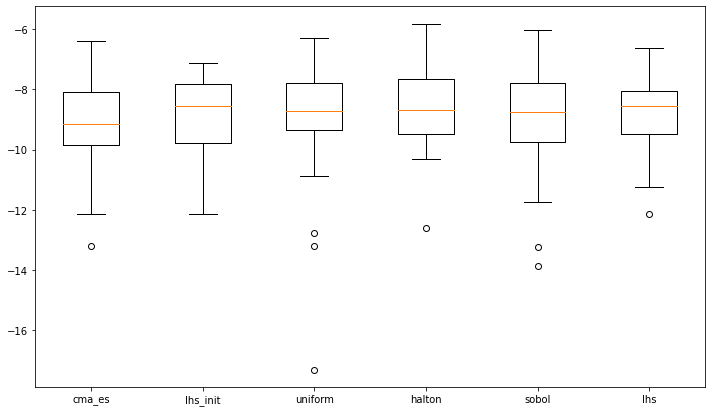

In [24]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['abs_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)

([<matplotlib.axis.XTick at 0x7f8b96325590>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

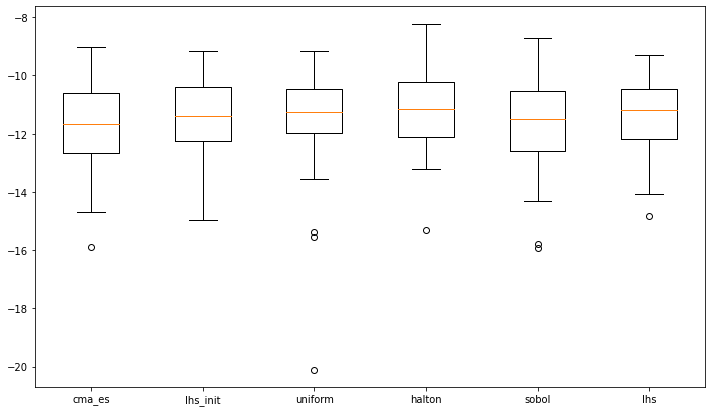

In [25]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['minmax_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)